In [40]:
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking as nimask
from nibabel.processing import resample_to_output
from matplotlib import pyplot as plt
import pickle

In [37]:
#LOADING IN
#one preprocessed scan
fmri_test_path = "NYU_0050954_func_preproc.nii"
#nibable image

#fmri_image_path = 'C:/Users/ahmm9/OneDrive - ITU/ITU/Research_proj/prepros_data/Outputs/ccs/filt_global/func_preproc'
fmri_image_path = '../../DATA/pre_proc_ABIDE1/func_preproc'
img = nib.load(fmri_test_path).get_fdata()

print(img.shape)
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


#parcellation mask
mask_path = 'Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii'
img2 = nib.load(mask_path).get_fdata()
img2.shape


(61, 73, 61, 175)
The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


(256, 256, 256, 1)

Plot data and mask

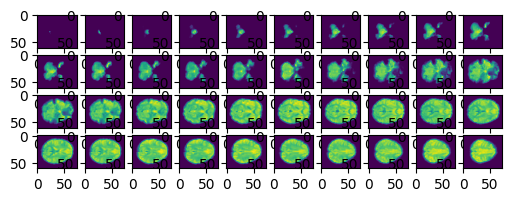

In [10]:
#frmi image
plt.style.use('default')
fig, axes = plt.subplots(4, 10, figsize=(6, 2))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:, :, i, 0])
plt.show()

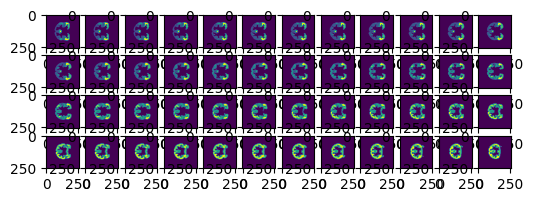

In [11]:
#Mask
plt.style.use('default')
fig, axes = plt.subplots(4, 12, figsize=(6, 2))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img2[:, :, 125 + i, 0])  
    # Start from the 31st image (index 30)#TODO still this with different indexing??
plt.show()


In [12]:
#load with NILearn
ni_image = nimg.load_img(fmri_test_path)
ni_mask = nimg.load_img(mask_path)
print(ni_image.shape)
print(ni_mask.shape)

(61, 73, 61, 175)
(256, 256, 256, 1)


In [13]:
#what is the affine of the image?
ni_image.affine

array([[  -3.,   -0.,   -0.,   90.],
       [  -0.,    3.,   -0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])

(256, 256, 256, 1)
(61, 73, 61, 175)


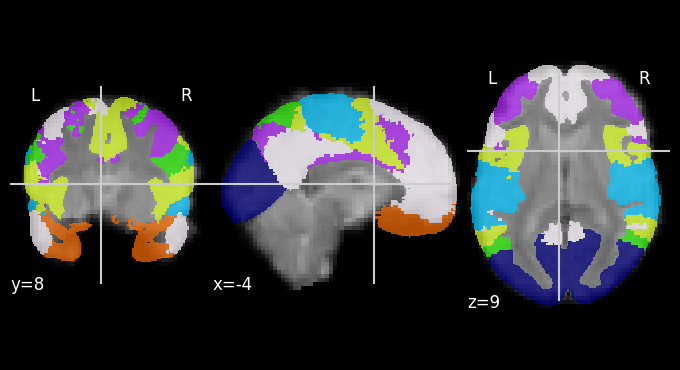

In [15]:
#show mask
nplot.plot_roi(ni_mask, ni_image.slicer[:,:,:,54])
print(ni_mask.shape)
print(ni_image.shape)

In [16]:
#nilearn reshape dims of mask to match
reshaped_mask = nimg.resample_img(ni_mask,target_affine=ni_image.affine, interpolation='nearest',target_shape=ni_image.shape[:3])
reshaped_mask.shape

(61, 73, 61, 1)

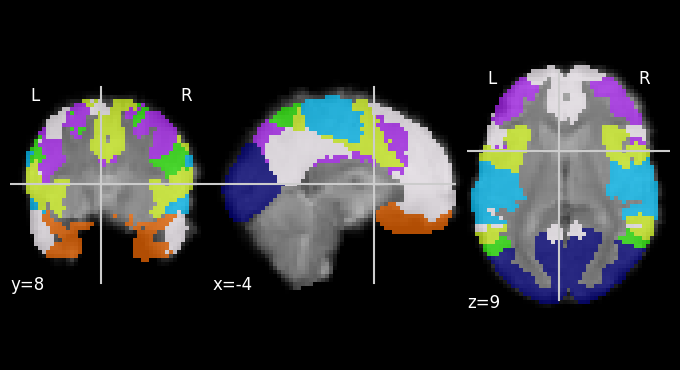

In [17]:
#plot the mask onto one slice of the frmi image
nplot.plot_roi(reshaped_mask, ni_image.slicer[:,:,:,5])

In [19]:
#creates a mask disctionary with separate the regions as keys and the region masks as values
def create_parcellation_masks(nifti_mask, nifti_image):
    # Load the data from the Nifti image
    data = nifti_mask.get_fdata().astype(int)
    
    # Create a dictionary to store each mask
    masks = {}
    for value in range(1, 8):  # Assuming values are between 1 and 7
        masks[value] = nib.Nifti1Image((data == value).astype(float), nifti_image.affine) # Create a mask for each unique value
    return masks

mask_dict = create_parcellation_masks(reshaped_mask,ni_image)
print(type(mask_dict[1]))
print(mask_dict[1].shape)

<class 'nibabel.nifti1.Nifti1Image'>
(61, 73, 61, 1)


In [21]:
mask_reasonable_shape = reshaped_mask.get_fdata().astype(int)[:,:,:,0]
not_brain = (mask_reasonable_shape == 0).sum()
brain = (mask_reasonable_shape != 0).sum()
print(brain,not_brain) # not brain is relative to parcellation
print("percentage of brain masked",(brain/(brain+not_brain))*100,"%")

39080 232553
percentage of brain masked 14.387059009766853 %


In [24]:
# #plot mask COMMENTED OUT BUT USEFUL
# output = {}
# means_no_threshold = []
# voxelsum = 0
# for i in range(1,8):
#     output[i] = nimask.apply_mask(ni_image, mask_dict[i])
#     nplot.plot_roi(mask_dict[i], ni_image.slicer[:,:,:,54])
#     nplot.show()
#     voxelsum += np.sum(output[i])
#     means_no_threshold.append(np.mean(output[i], axis = 1))
    
# print(means_no_threshold)
# print(means_no_threshold[1].shape)
# print(brain)
# print(voxelsum)
# threshold = voxelsum/brain
# print(threshold)

In [26]:
#applies mask to image
def apply_mask(image,mask):
    output_dict = {}
    for i in range(1,8):
        stack = []
        masked = nimask.apply_mask(image, mask[i])
        row_check = masked[0][masked[0] != 0]
        for row in masked:
            masked_no_zeros = row[row != 0]
            assert(len(masked_no_zeros) == len(row_check))
            stack.append(masked_no_zeros)
        output_dict[i] = np.array(stack)
    return output_dict

output2 = apply_mask(ni_image,mask_dict)


        

In [28]:
# #testing shapes
# some = output2[1][1][output2[1][1] != 0]
# some2 = output2[1][1][output2[1][1] == 0]

# # for i in range(1,175):
# #     print((output2[5][i][output2[5][i] != 0]).shape)
# print(some.shape)
# print(some2.shape)
# print(output2[1][1].shape)
# print(output2[1][1].shape[0]- some.shape[0])

In [30]:
# print(ni_image.shape)
# print(len(mask_dict))
# print(len(output2))
# print(output2[5].shape)
# print("here",np.sum(output2[5]==0.0,axis=1))
# print("here",output2[5]==0)

# print(np.array_equal(output[1], output2[1]))
# print(mask_dict[5].shape)


In [32]:
# for i in range (1,8):
#     print("here", np.max(np.sum(output2[i] == 0.0, axis=1)))



In [34]:
import os

def compute_voxel_count_total(data):
    voxel_count = 0
    for key in data.keys():
        voxel_count += len(data[key][0])
    return voxel_count

def compute_voxel_count_per_region(data,t = 0):
    voxel_count = 0
    for i in range(len(data.keys())):
        voxel_count += len(data[i+1][t])
    return voxel_count
# print(compute_voxel_count_per_region(output))


In [38]:
#get all images into list
all_images = []
seg = pd.read_csv("phenotypic_NYU.csv")
labels = []
for filename in os.listdir(fmri_image_path):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        file_path = os.path.join(fmri_image_path, filename)
        labels.append(int(seg[seg["SUB_ID"]==int(filename[6:11])]["DX_GROUP"]))
        img = nimg.load_img(file_path)
        all_images.append(img)
print(np.array(all_images).shape)
print(np.array(labels).shape)

#1:30 runtime, use paths instead if only running some


(171,)
(171,)


In [39]:
#check affine is same for all images
print(len(all_images))
prev_img = all_images[0]
for img in all_images:
    if (prev_img.affine != img.affine).all():
        print("different")
    prev_img = img

171


In [42]:
all_masked_images = []
start_index = 0
# running mask apply, save every 10th iteration, can be restarted and interrupted
try:
    with open('masked_image.pkl', 'rb') as f:
        print(f)
        all_masked_images = pickle.load(f)
        start_index = len(all_masked_images)
        print(f"Resuming from index {start_index}")
except FileNotFoundError:
    print("No previous save found, starting from scratch")
    
for i in range(start_index,len(all_images)):
    all_masked_images.append(apply_mask(all_images[i],mask_dict))
    if (i % 10 == 0):
        with open('masked_image.pkl', 'wb') as f:
            pickle.dump(all_masked_images,f)
        print("saved at index", i)

print("Applied mask to all images")

print(np.array(all_masked_images[0]).shape)
print(len(all_images) == len(all_masked_images))
print(all_images[0].shape[3] == len(all_masked_images[0][1]))

No previous save found, starting from scratch
saved at index 0
saved at index 10


KeyboardInterrupt: 

In [44]:
print(all_masked_images[0][5].shape)

(175, 2780)


In [45]:
#if timesteps isnt the same the calculaitons need to be weighted
# this bit checks all scans are 175 timesteps long
for i in range(len(all_images)):
    if all_images[i].shape[3] != 175:
        print( all_images[i] )

In [46]:
#not this one 
def threshold_per_timestep(data,time_steps):
    """each participant, each timestep"""
    thresholds = np.zeros((len(data),time_steps))
    for i in range(len(data)):
        for t in range(time_steps):
            voxel_sum = 0
            voxel_count = 0
            for k in range(len(data[i].keys())):
                voxel_sum += np.sum(data[i][k+1][t]) 
                print("data:", data[i][k+1][t])
                print("sum: ", np.sum(data[i][k+1][t]) )
                voxel_count += data[i][k+1].shape[1]
            print("voxelsum:", voxelsum)
            print("voxel_ count true:" , voxel_count)
            print("fdsopf", data[i][k+1].shape)
            means = voxel_sum/voxel_count
            print("means:", means)
            print("true:", data[i][1])
            thresholds[i][t] = means
    return thresholds

#not this one
def threshold_per_bin(data,bin_size, time_steps):
    """each participant, each bin (div by 5 is easiest)"""
    time_steps = int(time_steps/bin_size)
    thresholds = np.zeros((len(data),time_steps,7))
    for i in range(len(data)):
        for t in range(time_steps):
            voxel_sum = np.zeros(7)
            index_offset = t * bin_size
            voxel_count = 0
            for b in range(bin_size):
                voxel_count += compute_voxel_count_per_region(data[i],index_offset+b)  
                voxel_sum_temp = np.zeros(7)
                for k in range(len(data[i].keys())):
                    voxel_sum_temp[k] = np.sum(data[i][k+1][index_offset+b])  
                voxel_sum += voxel_sum_temp
            means = voxel_sum/voxel_count
            thresholds[i][t] = means
    return thresholds

#THIS ONE!!!
def threshold_per_participant(data,time_steps):
    """each participant, whole timeframe"""
    thresholds = np.zeros((len(data),7))
    for i in range(len(data)):
        voxel_sum = np.empty(7)
        voxel_count = compute_voxel_count_per_region(data[i],0) * time_steps 
        for k in range(len(data[i].keys())):
            voxel_sum[k] = np.sum(data[i][k+1])
        means = voxel_sum/voxel_count
        thresholds[i] = means
    return thresholds

#doesnt run just experimenting 
def threshold_participant_region_all_time(data):
    all_thesholds = []
    for participant in range(len(data)):
        print(participant)
        l_thresholds = [0 for i in range(len(data[0].keys()))] # set to 0 for all regions
        for i in range(len(l_thresholds)):
            # print(f"{i}:")
            # voxels in the mask by number of timesteps by number of participants in group
            voxel_count = len(data[0][i+1][0]) * len(data[0][i+1]) * sum(labels == l)

            voxel_sum = 0
            for participant in range(len(data)):
                if labels[participant] == l: # only within group

                #print(len(data[participant][i+1]))
                #print(np.sum(data[participant][i+1]))
                    voxel_sum += np.sum(data[participant][i+1])#[participant][region]
            l_thresholds[i] = voxel_sum/voxel_count
            all_thresholds.append(l_thresholds)
    return all_thresholds

# similar but needs to be not for groups
def threshold_groups_region_all_time(data,labels):
    """Add docu to functions. Also make more functions, fuck the free line scripting"""
    labels = np.array(labels)
    all_thresholds = dict()
    for l in set(labels):
        l_thresholds = [0 for i in range(len(data[0].keys()))] # set to 0 for all regions
        for i in range(len(l_thresholds)):
            # print(f"{i}:")
            # voxels in the mask by number of timesteps by number of participants in group
            voxel_count = len(data[0][i+1][0]) * len(data[0][i+1]) * sum(labels == l)

            voxel_sum = 0
            for participant in range(len(data)):
                if labels[participant] == l: # only within group

                #print(len(data[participant][i+1]))
                #print(np.sum(data[participant][i+1]))
                    voxel_sum += np.sum(data[participant][i+1])#[participant][region]
            l_thresholds[i] = voxel_sum/voxel_count
        all_thresholds[l]=l_thresholds
    return all_thresholds


In [ ]:
# #1  is autism 2 is TD/control
# #threshold_rat = threshold_participant_region_all_time(all_masked_images)
# threshold_grat = threshold_groups_region_all_time(all_masked_images,labels)
# threshold_grat
# #threshold_rat

In [52]:
# threshold_timestep = threshold_per_timestep(all_masked_images,175)
# print("timestep: ", threshold_timestep)
    

# group_threshold_timestep = threshold_timestep
# print(len(group_threshold_timestep))
# print(len(group_threshold_timestep[1]))
# print(len(group_threshold_timestep[2]))
# print("GTT_SHAPE:", group_threshold_timestep[0].shape)

# GTT_SHAPE = group_threshold_timestep[0].shape

# bin_size = 5
# threshold_bin = threshold_per_bin(all_masked_images,bin_size,175)
# print("bin: ", threshold_bin.shape)

# group_threshold_bin = np.transpose(threshold_bin,(0,2,1))
# print(len(group_threshold_bin))
# print(len(group_threshold_bin[1]))
# print(len(group_threshold_bin[2]))
# print("GTB_SHAPE: ",group_threshold_bin[0].shape)

# GTB_SHAPE = group_threshold_bin[0].shape

threshold_participant = threshold_per_participant(all_masked_images,175)
print("participant (participants,thresholds): ", threshold_participant.shape)
GTP_SHAPE = threshold_participant[0].shape


participant (participants,thresholds):  (11, 7)


In [ ]:
# def binarise(data,labels,thresholds):
#     labels = np.array(labels)
#     bin_by_group = {1:[],2:[]}
#     for scan_num,one_scan in enumerate(data):
#         image_label = labels[scan_num]
#         one_participant_bin = np.array(pd.DataFrame.from_dict(binarize_participant (one_scan,thresholds[image_label]),orient="index"))
#         bin_by_group[image_label].append(one_participant_bin)
#     for group in bin_by_group:
#         bin_by_group[group] = np.concatenate(bin_by_group[group],axis=1,dtype=int)
#     return for_eda_by_group
# 
# def binarize_participant(participant,thresholds):
#     means_with_threshold = dict()
#     for i in participant.keys():
#         mean_image = (np.mean(participant[i], axis = 1))-thresholds[i-1]
#         bin_image = np.where(mean_image>0, 1,-1)
#         means_with_threshold[i] = bin_image
#     return means_with_threshold

In [ ]:
## New version
def binarise(data,thresholds):
    bin_by_group = {1:[],2:[]}

    for scan_num,one_scan in enumerate(data):# for each participant
        if (scan_num == 0):#TODO delete only run one for now
            image_label = labels[scan_num]
            # Binarize for single participant
            one_participant_bin = np.array(pd.DataFrame.from_dict(apply_threshold(one_scan,thresholds[scan_num]),orient="index"))
            bin_by_group[image_label].append(one_participant_bin)

    for group in bin_by_group:
        if (len(bin_by_group[group]) > 0):
            bin_by_group[group] = np.concatenate(bin_by_group[group],axis=1,dtype=int)
    return bin_by_group

def apply_threshold(participant, thresholds):
    binarized_participant = dict()
    if thresholds.shape == GTP_SHAPE:
        for k in participant.keys():            
            # means = (np.mean(participant[k], axis = 1))-thresholds
            # if (i == 0):
            #     print("thresh:", thresholds, " mean:", np.mean(participant[k], axis = 1), " result: ", means)
            #     print("means shape: ", (np.mean(participant[k], axis = 0)).shape)
            # binarized_participant[k] = np.where(means>0, 1,-1)  
            print(len(participant), "type: ", type(participant))
            print(len(thresholds), "type:", type(thresholds)) 
            binarized_participant[k] = np.where(participant[k] > thresholds[k-1], 1, -1)
    else:
        raise ValueError("thresholds does have correct dimensions, found dimension:", thresholds.shape )
    return binarized_participant
    
#old DONT USE
def OLD_binarize_participant(participant,thresholds):
    new_participant = participant.copy()
    means_with_threshold = dict()
    for k in participant.keys():
        for t in range(len(participant[k])):
            participant[k][i]
        
        mean_image = (np.mean(participant[i], axis = 1))-thresholds[i-1]
        bin_image = np.where(mean_image>0, 1,-1)
        means_with_threshold[i] = bin_image
    return means_with_threshold

In [69]:
# holder = np.array(all_masked_images)
# print(holder.shape)
# print(len(holder[0]))
# print(len(holder[0][1]))
# print(len(holder[0][5][0]))

In [70]:
binarized = binarise(all_masked_images,threshold_participant)
binarized[1].shape

7 type:  <class 'dict'>
7 type: <class 'numpy.ndarray'>
7 type:  <class 'dict'>
7 type: <class 'numpy.ndarray'>
7 type:  <class 'dict'>
7 type: <class 'numpy.ndarray'>
7 type:  <class 'dict'>
7 type: <class 'numpy.ndarray'>
7 type:  <class 'dict'>
7 type: <class 'numpy.ndarray'>
7 type:  <class 'dict'>
7 type: <class 'numpy.ndarray'>
7 type:  <class 'dict'>
7 type: <class 'numpy.ndarray'>


C:\Users\nici9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


ValueError: could not broadcast input array from shape (175,6581) into shape (175,)

In [678]:
#save
for i in binarized.keys():
    np.savetxt(f"Binarized_Data_Group_{i}",binarized[i],fmt="%d",delimiter=",")

In [ ]:
#TODO:
# binarise
# is threshold different by group??? and perticipant?? and variance
# save the data, separate data by groups (structure)
# threshold by region
# sliding timeframes
# binsize
# concatenation of groups
# writing
# formatting of notebook


In [ ]:
# mean_activations = np.array(means)
# mean_activations.shape
# threshold